<a href="https://colab.research.google.com/github/HwangJae-won/De-suffled_Data_chanllenge/blob/main/De_Scrambling_Text_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## ❓ Problem statement
This problem is pretty straightforward. We have sentences which are scrambled and our only task is to de-scramble them so that they make sense.


> **Scrambled**:  borrow I may that book you from <br/>
>**Unscrambled**:  may I borrow that book from you

-> 어순을 맞게 고치거나 오타를 잡아내는 등 비문을 맞게 고치는 task


## 💪 Getting started

`Supervised Learning`  | `Natural Language Processing` |  `Seq2Seq`

These are the list of things that we will learn in this notebook.

- Getting started with Transformers
- Getting started with [🤗 HuggingFace](https://huggingface.co/) to make Sequence to Sequence predictions 
- Finetuning the BERT architecture for training and prediction on our own custom dataset


>**NOTE:** This notebook takes a lot of inspiration from [Leveraging Pre-trained Checkpoints for Encoder-Decoder Models](https://colab.research.google.com/drive/1WIk2bxglElfZewOHboPFNj8H44_VAyKE?usp=sharing#scrollTo=yoN2q0hZUbXN)

### Tech stack
![NumPy](https://img.shields.io/badge/numpy-%23013243.svg?style=for-the-badge&logo=numpy&logoColor=white&style="margin:0;margin-left:5px")
![Pandas](https://img.shields.io/badge/pandas-%23150458.svg?style=for-the-badge&logo=pandas&logoColor=white&style="margin:0;margin-left:5px")
![PyTorch](https://img.shields.io/badge/PyTorch-%23EE4C2C.svg?style=for-the-badge&logo=PyTorch&logoColor=white&style="margin:0;margin-left:5px")

## 💼 Setting our Workspace

AIcrowd API 따와서 데이터셋 다운로드 및 제출할 수 있도록 함 (API 접속 후 로그인하기)

In [ ]:
# Downloading the aicrowd pypi module
!pip install aicrowd-cli

# Make sure you re-run the code below whenever you restart the notebook
%load_ext aicrowd.magic

The aicrowd.magic extension is already loaded. To reload it, use:
  %reload_ext aicrowd.magic


% : 매직 커멘드, 폴더 경로 및 목록 등을 확인하는 명령어 

In [ ]:
# Logging in using our AIcrowd account. 
### IMPORTANT: Make sure you have accepted the puzzle rules before logging in!
%aicrowd login

In [ ]:
# Downloading the dataset
!rm -rf data
!mkdir data
%aicrowd ds dl --challenge de-shuffle-text -j 3 -o data

## 📦 Importing libraries

Here, we are going to use [HuggingFace🤗](https://huggingface.co/)! HuggingFace is a startup that has been growing rapidly in the recent years and deals with Natural Language Processing. They provide many open source NLP libraries such as [**transformers**](https://huggingface.co/transformers/), for using start-of-the-art transformers for NLP tasks and they also provide NLP [**datasets**](https://huggingface.co/docs/datasets/), and many evaluation metrics.

In [ ]:
# Installing
!pip install datasets transformers rich

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import os

import torch
import datasets
from datasets import load_dataset
from transformers import EncoderDecoderModel, EncoderDecoderConfig, BertTokenizerFast, Seq2SeqTrainingArguments, Seq2SeqTrainer, BertConfig

# To make the cell outputs more beautiful! 
from rich.console import Console
from rich.table import Table
from rich import pretty
pretty.install()

# To display YouTube videos
from IPython.display import YouTubeVideo

## 🗃️ Data setup

In this section, we will be reading in the datasets and looking at what's inside them.

### Loading and reading the data

In [ ]:
train_dataset = pd.read_csv("data/train.csv")
validation_dataset = pd.read_csv("data/val.csv")
test_dataset = pd.read_csv("data/test.csv")

### Reviewing the data

In [ ]:
# Let's take a look at what the dataset contains
train_dataset

,text,label,id
0,"presented here Furthermore, naive improved. im...","Furthermore, the naive implementation presente...",0
1,vector a in a form vector multidimensional spa...,Those coefficients form a vector in a multidim...,1
2,compatible of The model with recent is model s...,The model is compatible with a recent model of...,2
3,but relevance outlined. hemodynamics its based...,"The model is based on electrophysiology, but i...",3
4,of transitions lever-like involve reorientatio...,Conformational transitions in macromolecular c...,4
...,...,...,...
39996,for pose a clutter. estimation autonomous mani...,Object pose estimation is a crucial prerequisi...,39996
39997,objects added warehouses bin-picking present s...,Real-world bin-picking settings such as wareho...,39997
39998,validation The proposed real-world on is metho...,The proposed method is evaluated on a syntheti...,39998
39999,a between modes. statistics survival qualitati...,This breakdown is associated with a crossover ...,39999


As we can see, the **text** column contains scrambled sentences and the **label** column contains the sentences with the words in the correct order. 

In the cell below, we are using huggingface's dataset library to load our dataset. As you will see, this will help a lot in preprocessing our text, and creating batches to put into the transformer model! 

In [ ]:
# Loading the training, validation and test datasets
dataset = load_dataset('csv', data_files={"train"     : ["data/train.csv"], 
                                          "validation": ["data/val.csv"], 
                                          "test"      : ["data/test.csv"]})
dataset

WARNING  Using custom data configuration default-5397148d28c8f386

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-5397148d28c8f386/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'id'],
        num_rows: 40001
    })
    validation: Dataset({
        features: ['text', 'label', 'id'],
        num_rows: 4001
    })
    test: Dataset({
        features: ['text', 'label', 'id'],
        num_rows: 10000
    })
})

## ⚙️Data pre-processing

There's a lot that's about to happen here, let's go through it cell-by-cell.

### Understanding the BERT tokenizer


In simple terms, tokenization -

* Splits our senteces into individuals words/sub words that can't be divided more. The words/sub words still have the meaning.

* Using Rule Based Methods to -

  * Fine-tune and break the letters even more if possible
  * Removing non-essential characters like punctuations marks, etc. 


In [ ]:
# We are importing our tokenizer from the transformers library. Now the bert-base-uncased is the pretrained bert model, (here uncased means that it was trained using only lowercase words) 
# So we will be using bert-base-uncased as our pretrained model for tokenization 

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
tokenizer

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

PreTrainedTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

Above, you can see that the tokenizer has many parameters by default. **vocab size** is the number of elements in a set of the words familiar to the tokenizer, **max length** is the total number of tokens the model can give as output. We will talk about the padding soon. 
Special tokens like **unk token** represent a word found in the input text which was not in the vocabulary of the model. There are other tokens too, like the **sep token** which separates sentences in an input text.

In [ ]:
sample_text = train_dataset['label'][0]
sample_text

'Furthermore, the naive implementation presented here can be improved.'

In [ ]:
# Splitting the input sentence into words
tokens = tokenizer.tokenize(sample_text)

# Convert the unique words into specific numbers which are already mapped by the pretrained bert model 
token_ids = tokenizer.convert_tokens_to_ids(tokens)


print("Sample Text : ", sample_text)
print("Tokens      : ", tokens)
print("Token Ids   : ", token_ids)

Sample Text :  Furthermore, the naive implementation presented here can be improved.
Tokens      :  ['furthermore', ',', 'the', 'naive', 'implementation', 'presented', 'here', 'can', 'be', 'improved', '.']
Token Ids   :  [7297, 1010, 1996, 15743, 7375, 3591, 2182, 2064, 2022, 5301, 1012]


In [ ]:
# To convert a token id back to its origin string, we can simply use:

output_text = tokenizer.decode(token_ids)
output_text

'furthermore, the naive implementation presented here can be improved.'

### Creating the dataset

In [ ]:
# To have consistent dimensions of output vector accross the samples, we have to set the maximam number of tokens for each sample.  
MAX_TEXT_LENGTH = 40
MAX_LABEL_LENGTH = 40

def preprocess_function(sample):
  
  # Getting the text and label
  text = sample["text"]
  label = sample["label"]

  # Tokenizing the text and label
  inputs = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_TEXT_LENGTH)
  outputs = tokenizer(label, padding="max_length", truncation=True, max_length=MAX_LABEL_LENGTH)


  sample["input_ids"] = inputs.input_ids
  sample["attention_mask"] = inputs.attention_mask
  sample["decoder_input_ids"] = outputs.input_ids
  sample["decoder_attention_mask"] = outputs.attention_mask
  sample["labels"] = outputs.input_ids

  # The labels are used to calcuate the loss while training, and because we added padding to make all tokens to be of same size,
  # we also need to convert the padding number ( 0 ) to ( -100 ), so that we can tell huggingface that these number can be ignorned while calcuating the loss. 
  # Why specifically -100 ? It's simply an arbitrary number, again so that huggingface can ignore this number while calcuating loss
      
  sample["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in sample["labels"]]

  return sample

So, let's talk about padding, truncation and this max length stuff! Similar to convolutional neural networks, which require images to be of the same size, transformers also require to have the tokens be of the same length. But sentences can be of different lengths, so what do we do? 

Let's consider an example, these are three sentences -
1. *i have bought several of the vitality*
2. *food products and have found them all to be of good quality*
3. *my labrador is finicky and she appreciates this product better than most*

And we set our `max tokens` to be 9. 

Here are the correspoding token ids of the sentences - 
1. `[1045, 2031, 4149, 2195, 1997, 1996, 8995, 3012]`
2. `[2833, 3688, 1998, 2031, 2179, 2068, 2035, 2000, 2022, 1997, 2204, 3737]`
3. `[2026, 18604, 2003, 10346, 6799, 2100, 1998, 2016, 9120, 2015, 2023, 4031, 2488, 2084, 2087]`

Now, all these 3 lists have different lengths. To make them be of the same length, we use 2 things, **padding** and **truncation** - 
1. In **padding**, we simply add zero ( 0 ), either on the left or to the right to make the tokens be the same length as `max tokens`. In the case of sentence no.1, padding will be added like so (notice how the length is now 9).
  1. `[1045, 2031, 4149, 2195, 1997, 1996, 8995, 3012, 0]`

2. In **truncation**, we simply remove the token ids, either on the left or on the right, to make the sentences the same length as `max tokens`. 
  2. `[2833, 3688, 1998, 2031, 2179, 2068, 2035, 2000, 2022]`
  3. `[2026, 18604, 2003, 10346, 6799, 2100, 1998, 2016, 9120]`

The **`attention_mask`** for decoder ( label ) and input ( text ) is simply a list with `1` where no paddded is added and `0` for where padding is added!

In [ ]:
# Applying the preprocessing to every sample

BATCH_SIZE = 16
      
tokenized_datasets = dataset.map(preprocess_function, batch_size=BATCH_SIZE, batched=True)

  0%|          | 0/2501 [00:00<?, ?ba/s]

  0%|          | 0/251 [00:00<?, ?ba/s]

  0%|          | 0/625 [00:00<?, ?ba/s]

In [ ]:
# Convert the list into torch tensor
tokenized_datasets.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [ ]:
print(tokenized_datasets['train'][0].keys())
tokenized_datasets['train'][0], tokenized_datasets['train'][1]

dict_keys(['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask', 'labels'])


(
    {
        'input_ids': tensor([  101,  3591,  2182,  7297,  1010, 15743,  5301,  1012,  7375,  2022,
         1996,  2064,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
        'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'decoder_input_ids': tensor([  101,  7297,  1010,  1996, 15743,  7375,  3591,  2182,  2064,  2022,
         5301,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
        'decoder_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'labels': tensor([  101,  7297,  1010,  1996, 15743,  7375,  3591,  2182,  2064,  2022,
         5301,  1012,   102,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])
    },
    {
        'input_ids': tensor([  101,  9207,  1037,  1999,  1037,  2433,  9207,  4800, 22172,  6132,
        19301,  2686,  1012,  2216, 21374,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
        'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'decoder_input_ids': tensor([  101,  2216, 21374,  2433,  1037,  9207,  1999,  1037,  4800, 22172,
         6132, 19301,  9207,  2686,  1012,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
        'decoder_attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'labels': tensor([  101,  2216, 21374,  2433,  1037,  9207,  1999,  1037,  4800, 22172,
         6132, 19301,  9207,  2686,  1012,   102,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100])
    }
)

## 🛠️ Model building

We are now creating transformers!

What are transformers? They are a deep learning architecture which solve **Sequence to Sequence** problems. What are Sequence to Sequence problems? 
Basically it's an NLP problem where we want to map an input sequence (a sentence) to an output sequence of a potentially different length (another sentence in most cases). A common example is translation.

A question you might have is why are we using transformers, is an LSTM not enough? Well, the main issue about LSTMs are that they are: 
1. slow to train
2. fail to retain the information in a text for longer periods of time. 
3. LSTM still weren't able to fully erase the **vanishing gradient** problem which plagued RNNs. Vanishing gradient is the problem that occurs during backpropagation, when the change in the weights in the first few layers becomes pretty much negligible when it comes to the last few layers.  

A new research paper, [Attention Is All You Need](https://arxiv.org/abs/1706.03762) solved many of these issues. Transformers were hugely inspired by attention mechanisms. To learn more about attention; the blog (no. 1) below has a lot of visualisations about it, go and check it out! After that, you are ready to understand transformers!

Here are some great links which talk about Seq2Seq models -   
1. **[Visualizing A Neural Machine Translation Model (Mechanics of Seq2Seq Models With Attention)](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/)** blog by [Jay Alammar](https://twitter.com/JayAlammar)  
2. [**The Illustrated Transformer**](https://jalammar.github.io/illustrated-transformer/) by the same author.  

And now you will be ready to understand BERT, after reading this blog! [**A Visual Guide to Using BERT for the First Time**](https://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/)

Optional resources, but helpful - 
-  [**Interfaces for Explaining Transformer Language Models**](https://jalammar.github.io/explaining-transformers/)
-  [**Finding the Words to Say: Hidden State Visualizations for Language Models**](https://jalammar.github.io/hidden-states/)

You would have probably guessed by now that transformers are a bit tricky to understand. That's why these blogs with their visualizations are a great way to understand this tricky concept!

In [ ]:
# Using a pretrained BERT Model
model = EncoderDecoderModel.from_encoder_decoder_pretrained("bert-base-uncased", "bert-base-uncased")

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relations

In [ ]:
# The model architecture
model

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (1): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (2): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): BertIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GELUActivation()
          )
          (output): BertOutput(
            (dense): Linear(in_features=3072, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (3): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_featur

## 🚀 Model Training

### Setting up training

In [ ]:
# Setting up the parameters
model.config.decoder_start_token_id = tokenizer.cls_token_id # ID of the classification token
model.config.eos_token_id = tokenizer.sep_token_id # ID of the separation  token
model.config.pad_token_id = tokenizer.pad_token_id # ID of the padding token 
model.config.vocab_size = model.config.encoder.vocab_size # Number of unique tokens in the model

In [ ]:
# Setting up the batch size, number of epochs

N_EPOCHS = 1

args = Seq2SeqTrainingArguments(
    "Scambled Text",  # Output directory of the training 
    evaluation_strategy = "epoch", 
    per_device_train_batch_size=BATCH_SIZE,  # Number of samples for each step of training 
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=N_EPOCHS, # Number of epochs to train
    fp16=True, # This will help in increasing the speed of training
)

In [ ]:
# Setting up training

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

Using amp half precision backend


### Training

In [ ]:
# This will take around 20-25 minutes 

trainer.train()

The following columns in the training set  don't have a corresponding argument in `EncoderDecoderModel.forward` and have been ignored: id, text. If id, text are not expected by `EncoderDecoderModel.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 40001
  Num Epochs = 1
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2501
/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:530: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models 

Epoch,Training Loss,Validation Loss
1,0.000400,0.000023


Saving model checkpoint to Scambled Text/checkpoint-500
Configuration saved in Scambled Text/checkpoint-500/config.json
Model weights saved in Scambled Text/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:530: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
Saving model checkpoint to Scambled Text/checkpoint-1000
Configuration saved in Scambled Text/checkpoint-1000/config.json
Model weights saved in Scambled Text/checkpoint-1000/pytorch_model.bin
/usr/local/lib/python3.7/dist-packages/transformers/models/encoder_decoder

TrainOutput(global_step=2501, training_loss=0.03158827158438057, metrics={'train_runtime': 5672.514, 'train_samples_per_second': 7.052, 'train_steps_per_second': 0.441, 'total_flos': 1917091990101600.0, 'train_loss': 0.03158827158438057, 'epoch': 1.0})

In the meantime, do make sure to watch [Illustrated Guide to Transformers Neural Network: A step by step explanation
](https://youtu.be/4Bdc55j80l8) by [Michael Phi
](https://twitter.com/LearnedVector), it's a really beautiful video to understand transformers mroe deeply! 

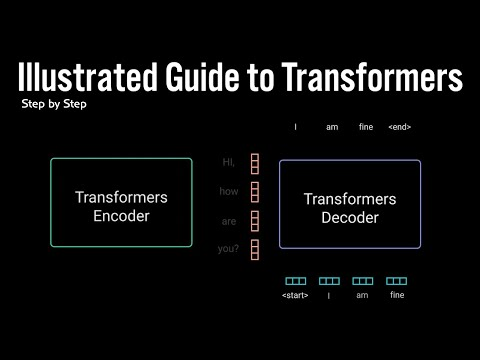

In [ ]:
YouTubeVideo('4Bdc55j80l8')



## 🔍 Evaluation

Phew! That was a lot to grasp! Anyways, let's write a helper function that will help us get the predictions.

In [ ]:
# Getting the predictions
def generate_predictions(batch):

    # Tokenizing the test
    inputs = tokenizer(batch["text"], padding="max_length", truncation=True, max_length=MAX_TEXT_LENGTH, return_tensors="pt")
    
    # Sending the tensors to GPU
    input_ids = inputs.input_ids.to("cuda")
    attention_mask = inputs.attention_mask.to("cuda")

    # Generating the predicted tokens ids
    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # Converting the token ids to sentence
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    batch["predictions"] = output_str

    return batch

In [ ]:
# Getting all results
results = dataset['test'].map(generate_predictions, batched=True, batch_size=16)
results = results.data.to_pandas()
results.head()

WARNING  Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/default-53
         97148d28c8f386/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c8351
         9/cache-a3b7601fe0bc54a8.arrow

,text,label,id,predictions
0,safely objects move. that system images detect...,"system Using approach, move. safely skip of th...",0,
1,We detectors popular influence of confidences ...,confidences popular different in detectors We ...,1,
2,compact coding present supervised We a approac...,"We a supervised approach, compact present codi...",2,
3,study high-throughput vital of quantitative be...,is for and individuals study of of collective ...,3,
4,on data sets. We evaluate method many challeng...,sets. challenging the data We method on many e...,4,


In [ ]:
test_dataset.head() # Note the labels are not the true labels since it is the test set.

,id,text,label
0,0,safely objects move. that system images detect...,
1,1,We detectors popular influence of confidences ...,
2,2,compact coding present supervised We a approac...,
3,3,study high-throughput vital of quantitative be...,
4,4,on data sets. We evaluate method many challeng...,


In [ ]:
test_dataset['label'] = results['label'] # Replace labels with our predictions
test_dataset

,id,text,label
0,0,safely objects move. that system images detect...,"system Using approach, move. safely skip of th..."
1,1,We detectors popular influence of confidences ...,confidences popular different in detectors We ...
2,2,compact coding present supervised We a approac...,"We a supervised approach, compact present codi..."
3,3,study high-throughput vital of quantitative be...,is for and individuals study of of collective ...
4,4,on data sets. We evaluate method many challeng...,sets. challenging the data We method on many e...
...,...,...,...
9995,9995,"particular i.e. problem, of to due However, na...","the i.e. of problem, However, particular to th..."
9996,9996,Simulation methods. proposed outperforming met...,state-of-the-art the that of Simulation demons...
9997,9997,in This view introduces a scenarios. paper tec...,used label introduces in placement scenarios. ...
9998,9998,valve. water from water are and pipeline sourc...,source noise interference of The are valve. pi...


##  ✅ Submission

Now let us take the dataframe with the predictions and submit it to get our scores!

> **NOTE** : Please make sure that there is a file called `submission.csv` in the `assets` folder before submitting

In [ ]:
!mkdir assets
test_dataset.to_csv(os.path.join("assets", "submission.csv"), index=False)

mkdir: cannot create directory ‘assets’: File exists


### Uploading the results 
> **NOTE** : Please save the notebook before submitting it (Ctrl + S)

In [ ]:
%aicrowd notebook submit -c de-shuffle-text -a assets --no-verify

Congratulations🎉! You did it! But there still a lot of improvements that can be made. 

1. You can try changing many hyperparameters and things like the epochs, learning rate or try different model architectures!

Also,  very recently as of April 2022 a new huge language model was release from Google called **PaLM : Pathways Language Model (PaLM): Scaling to 540 Billion Parameters for Breakthrough Performance**. Check out the blog from google [here](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html).

PS: don't be shy to ask questions related to any errors you are facing or doubts in any part of this notebook in our [AIcrowd discord sever](https://discord.gg/T6uZSWBMSZ), AIcrew will be happy to help you :)

## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out [here](https://www.aicrowd.com/showcase/baseline-de-shuffle-text). 

In [ ]:
submission = test_df

In [ ]:
!rm -rf assets
!mkdir assets
submission.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c de-shuffle-text -a assets --no-verify

Using notebook: Getting Starter Kit for De-Shuffle Text for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                       
                                       │ Successfully submitted! │                                       
                                       ╰─────────────────────────╯

                                             Important links                                             
┌──────────────────┬────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/de-shuffle-text/submissions/177885              │
│                  │                                                                                    │
│  All submissions │ https://www.aicrowd.com/challenges/de-shuffle-text/submissions?my_submissions=true │
│                  │                                                                                    │
│      Leaderboard │ https://www.aicrowd.com/challenges/de-shuffle-text/leaderboards                    │
│                  │                                                                                    │
│ Discussion forum │ https://discourse.aicrowd.com/c/de-shuffle-text                                    │
│                  │                                                                                    │
│   Challenge page │ https://www.aicrowd.com/challenges/de-shuffle-text                                 │
└──────────────────┴────────────────────────────────────────────────────────────────────────────────────┘